**Data Source :-** https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews<br>
**This whole notebook takes 35 minutes to run.**

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from matplotlib.pyplot import rcParams
from tqdm import tqdm
from nltk.corpus import stopwords
from scipy.stats import uniform
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, confusion_matrix, precision_recall_curve, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.metrics.classification import log_loss
import prettytable
from prettytable import PrettyTable

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
%matplotlib inline
rcParams["figure.figsize"] = 10,10

In [4]:
data = pd.read_csv("IMDB Dataset.csv")
print("There are {} rows & {} columns in our data-set.".format(data.shape[0], data.shape[1]))
data.head(10)

There are 50000 rows & 2 columns in our data-set.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data[data.isnull().any(axis=1)]

,review,sentiment


So, we can see that there are no missing values in our data.

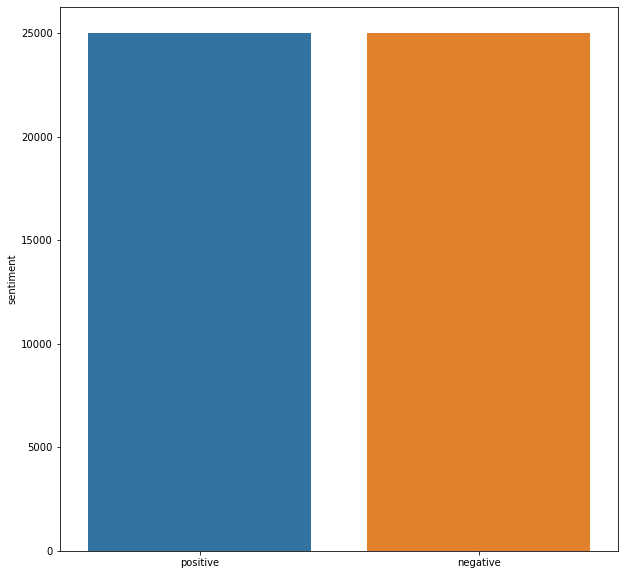

In [7]:
sns.barplot(x=data.sentiment.value_counts().index, y=data.sentiment.value_counts())
plt.show()

So, as we can see that our data is properly balanced. 

# Data Cleaning & Pre-Processing :-

In [8]:
print(data.review[10])
print("="*100)
print(data.review[1000])
print("="*100)
print(data.review[10000])
print("="*100)
print(data.review[49000])

Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"
This movie is awful, I can't even be bothered to write a review on this garbage! All i will say it is one of the most boring films I've ever seen.<br /><br />And the acting is very bad. The boy who plays the main character really annoys me, he's got the same expression on his face through out the movie. I just want to slap him! Basically 80% of the movie is slow motion shots of skateboarders, weird music, and utter sh

So, we can see that these reviews are in a need to be cleaned and then to be pre-processed.

In [9]:
data.review = data.review.apply(lambda a: a.lower())

In [10]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']
lemmatizer = WordNetLemmatizer()

We will use stopwords to reduce the number of features which will be created after BagOfWords / TF-IDF.

In [11]:
# start_time = timer(None) # timing starts from this point for "start_time" variable
preprocessed_review = []
for sentance in tqdm(data.review.values):
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', " ", sentance)    
    sentance = ' '.join(lemmatizer.lemmatize(text) for text in sentance.split() if text not in stopwords)
    preprocessed_review.append(sentance.strip())
# timer(start_time) # timing ends here for "start_time" variable

100%|██████████| 50000/50000 [02:04<00:00, 400.04it/s]


In [12]:
print(preprocessed_review[10])
print("="*100)
print(preprocessed_review[1000])
print("="*100)
print(preprocessed_review[10000])
print("="*100)
print(preprocessed_review[49000])

phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet
movie awful even bothered write review garbage say one boring film ever seen acting bad boy play main character really annoys got expression face movie want slap basically movie slow motion shot skateboarder weird music utter sh apparently got write least line text submit comment use line saying lead character got one face want slap meh give movie suck
sporadically engrossing including effectively tender moment humorous sledgehammer obvious satire homecoming hinge come forced ultimately unfulfilling material like timing everything michael moore knew release fahrenheit election real tragedy dante film come year ago message would carrie

In [13]:
preprocessed_review = pd.Series(preprocessed_review)
preprocessed_review.name = "final_reviews"
preprocessed_review

0        one reviewer mentioned watching oz episode hoo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movie high art fan expec...
Name: final_reviews, Length: 50000, dtype: object

Now, all the reviews are cleaned & are all set to go for pre-processing step.


In [14]:
target = data.sentiment
target = target.map({"positive":1, "negative":0})
target

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

# Splitting The Reviews :-

In [15]:
X = preprocessed_review
y = target
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr)
print("Length of X_train :- ", len(X_train))
print("Length of y_train :- ", len(y_train))
print("Length of X_test :- ", len(X_test))
print("Length of y_test :- ", len(y_test))
print("Length of X_cv :- ", len(X_cv))
print("Length of y_cv :- ", len(y_cv))

Length of X_train :-  32000
Length of y_train :-  32000
Length of X_test :-  10000
Length of y_test :-  10000
Length of X_cv :-  8000
Length of y_cv :-  8000


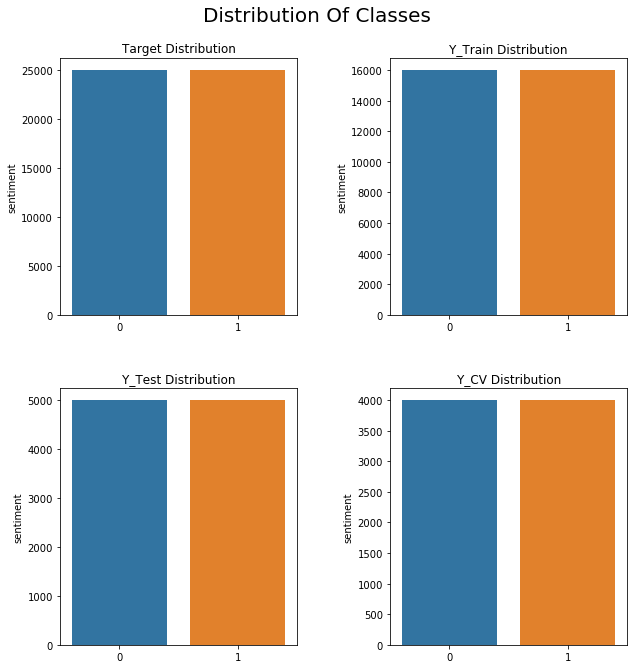

In [16]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
sns.barplot(x=target.value_counts().index, y=target.value_counts(), ax=axes[0,0]).set_title("Target Distribution")
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(), ax=axes[0,1]).set_title("Y_Train Distribution")
sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(), ax=axes[1,0]).set_title("Y_Test Distribution")
sns.barplot(x=y_cv.value_counts().index, y=y_cv.value_counts(), ax=axes[1,1]).set_title("Y_CV Distribution")
plt.suptitle("Distribution Of Classes", fontsize=20)
plt.tight_layout(pad=5, h_pad=4, w_pad=4)
plt.show()

# Featurization :-

In [17]:
bow = CountVectorizer(ngram_range=(1,2), min_df=2)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
X_cv_bow = bow.transform(X_cv)
print("Unique Features of X_Train :- ", X_train_bow.get_shape()[1])
print("Unique Features of y_Test :- ", X_test_bow.get_shape()[1])
print("Unique Features of X_CV :- ", X_cv_bow.get_shape()[1])

Unique Features of X_Train :-  435258
Unique Features of y_Test :-  435258
Unique Features of X_CV :-  435258


# Model Making With Hyperparameter Tunning :-

## Naive Bayes {Multi-Nomianl Bayes} :-

In [18]:
# alpha = [10**i for i in range(-5,1)]
# alpha = {"alpha": alpha}
# alpha

In [19]:
# # MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
# mnb = MultinomialNB()
# gscv_mnb = GridSearchCV(estimator=mnb, param_grid=alpha, cv=5, scoring="roc_auc")
# gscv_mnb.fit(X_train_bow, y_train)
# gscv_mnb.best_estimator_

In [20]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train_bow, y_train)
pre_test_mnb = mnb.predict(X_test_bow)
pre_cv_mnb = mnb.predict(X_cv_bow)

In [21]:
print("Log-Loss :- ",log_loss(y_test, mnb.predict_proba(X_test_bow)[:,1]))
print("Accuracy Score :-",accuracy_score(y_test, mnb.predict(X_test_bow))*100)
print("ROC-AUC Score :- ", roc_auc_score(y_test, mnb.predict_proba(X_test_bow)[:,1])*100)

Log-Loss :-  1.326461584490482
Accuracy Score :- 88.31
ROC-AUC Score :-  94.25765


## Random Forest :-

**Parameters that can be tunned in Random Forest for better performance of model :-**<br>
**n_estimators =** number of trees in the foreset<br>
**max_features =** max number of features considered for splitting a node<br>
**max_depth =** max number of levels in each decision tree<br>
**min_samples_split =** min number of data points placed in a node before the node is split<br>
**min_samples_leaf =** min number of data points allowed in a leaf node<br>
**bootstrap =** method for sampling data points (with or without replacement)<br>

In [22]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 4)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [None]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 4]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
#             'criterion':['gini', 'entropy']}
# print(random_grid)

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# # Old parameters set (But I wasn't able to know how much time it takes as my system has low configurations):-
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# # It took 1 hour & 12 minutes and gave best as :-
# {'n_estimators': 500,
#  'min_samples_split': 4,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}
# # Parameters gave :-
# {'n_estimators': [100, 233, 366, 500],
#  'max_features': ['auto', 'sqrt'],
#  'max_depth': [None],
#  'min_samples_split': [2, 4],
#  'min_samples_leaf': [1, 2],
#  'bootstrap': [True]}

# # Result :-
# Log-Loss :-  0.49990969167631555
# Accuracy Score :- 87.83999999999999
# ROC-AUC Score :-  94.891164

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# It took 26 minutes to train direct model with parameters :-
# n_estimators : 1000 & criterion : "entropy"

# # Result :-
# Log-Loss :-  0.43460243482048083
# Accuracy Score :- 87.92
# ROC-AUC Score :-  94.89314200000001

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

In [23]:
# start_time = timer(None)
# rf = RandomForestClassifier()
# rscv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=3, n_jobs=-1, random_state=42)
# rscv.fit(X_train_bow, y_train)
# timer(start_time)

In [24]:
# rscv.best_estimator_

In [25]:
# rscv.best_params_

**So, we after trying many models, I think the one with {'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5} parameters are best as they give us better logloss value than others. However, I know that there is not much of difference among all the Random Forest models I tried. Still these parameters gave best output so will choose them.**

In [26]:
# 26min for this :-
rf = RandomForestClassifier(criterion="entropy", n_estimators=1000,n_jobs=-1, random_state=42)
rf.fit(X_train_bow,y_train)
pre_test_rf = rf.predict(X_test_bow)
pre_cv_rf = rf.predict(X_cv_bow)

In [27]:
print("Log-Loss :- ",log_loss(y_test, rf.predict_proba(X_test_bow)[:,1]))
print("Accuracy Score :-",accuracy_score(y_test, rf.predict(X_test_bow))*100)
print("ROC-AUC Score :- ", roc_auc_score(y_test, rf.predict_proba(X_test_bow)[:,1])*100)

Log-Loss :-  0.4349706491603666
Accuracy Score :- 88.07000000000001
ROC-AUC Score :-  94.905328


## XGBoost :-


In [28]:
# params={
#  "learning_rate"    : [0.3, 0.4, 0.5, 1],
#  "gamma"            : [0.1, 0.3, 0.5],
#  "colsample_bytree" : [0.5, 1, 1.5]    
# }
# print(params)

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# # On Basic xgboost (time taken 3 minutes & 34.61 seconds) :-
# Log-Loss :-  0.3247937654944864
# Accuracy Score :- 86.41
# ROC-AUC Score :-  93.92870799999999

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# # It took 42 minutes & 28.23 seconds with these parameters:-
# {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
# 'min_child_weight': [1, 3],
# 'gamma': [0.0, 0.1, 0.2],
# 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

# # Best result from {'min_child_weight': 1, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.5} :-
# Log-Loss :-  0.32574999872817206
# Accuracy Score :- 86.15
# ROC-AUC Score :-  93.884524

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

# # It took 20 minutes and 34.37 seconds with these parameters :-
# {'learning_rate': [0.3, 0.4, 0.5, 1],
#  'gamma': [0.1, 0.3, 0.5],
#  'colsample_bytree': [0.5, 1, 1.5]}

# # Best result from {'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5} :-
# Log-Loss :-  0.3242997018728311
# Accuracy Score :- 86.67
# ROC-AUC Score :-  93.99489199999998

# X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X==X

In [29]:
# start_time = timer(None)
# xgb = XGBClassifier()
# rscv = RandomizedSearchCV(estimator=xgb, param_distributions=params, cv=3, n_jobs=-1)
# rscv.fit(X_train_bow, y_train)
# timer(start_time)

In [30]:
# print(rscv.best_estimator_)
# print(rscv.best_params_)

**So, we after trying many models, I think the one with {'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5} parameters are best as they give us better logloss value than others. However, I know that there is hardly any difference among all the xgboost models i tried. Still these parameters gave best output so will choose them.**

In [31]:
# start_time = timer(None)
xgb = XGBClassifier(learning_rate= 0.3, gamma=0.3, colsample_bytree=0.5, random_state=42, n_jobs=-1)
xgb.fit(X_train_bow, y_train)
# timer(start_time)
pre_test_rf =xgb.predict(X_test_bow)
pre_cv_rf = xgb.predict(X_cv_bow)

In [32]:
print("Log-Loss :- ",log_loss(y_test, xgb.predict_proba(X_test_bow)[:,1]))
print("Accuracy Score :-",accuracy_score(y_test, xgb.predict(X_test_bow))*100)
print("ROC-AUC Score :- ", roc_auc_score(y_test, xgb.predict_proba(X_test_bow)[:,1])*100)

Log-Loss :-  0.32301326711462314
Accuracy Score :- 86.46000000000001
ROC-AUC Score :-  94.06101199999999


## Logistic Regression :-

In [33]:
# # It took 38 minutes and 49.65 seconds for these parameters :-
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter distribution using uniform distribution
# C = uniform(loc=0, scale=4)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# Best Result from {'C': 0.13755408446087358, 'penalty': 'l2'} :- 
# Log-Loss :-  0.25661248589812646
# Accuracy Score :- 90.21000000000001
# ROC-AUC Score :-  96.11215999999999


In [34]:
# start_time = timer(None)
# log = LogisticRegression()
# rscv = RandomizedSearchCV(estimator=log, param_distributions=hyperparameters, random_state=42, n_iter=100, cv=5, verbose=0, n_jobs=-1)
# rscv.fit(X_train_bow, y_train)
# timer(start_time)

In [35]:
# rscv.best_estimator_

In [36]:
# rscv.best_params_

In [37]:
log = LogisticRegression(C=0.13755408446087358, random_state=42, n_jobs=-1)
log.fit(X_train_bow,y_train)
pre_test_log =log.predict(X_test_bow)
pre_cv_log = log.predict(X_cv_bow)

In [38]:
print("Log-Loss :- ",log_loss(y_test, log.predict_proba(X_test_bow)[:,1]))
print("Accuracy Score :-",accuracy_score(y_test, log.predict(X_test_bow))*100)
print("ROC-AUC Score :- ", roc_auc_score(y_test, log.predict_proba(X_test_bow)[:,1])*100)

Log-Loss :-  0.25663606401033306
Accuracy Score :- 90.2
ROC-AUC Score :-  96.112212


# Conclusion (Pretty Table) :-

In [74]:
pt = PrettyTable()
pt.field_names = ["Model", "Log-Loss", "ROC-AUC Score","Accuracy"]
pt.add_row(["Logistic {Test}", round(log_loss(y_test, log.predict_proba(X_test_bow)[:,1]), 4), round(roc_auc_score(y_test, log.predict_proba(X_test_bow)[:,1])*100, 2), round(accuracy_score(y_test, log.predict(X_test_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["XGBoost {Test}", round(log_loss(y_test, xgb.predict_proba(X_test_bow)[:,1]), 4), round(roc_auc_score(y_test, xgb.predict_proba(X_test_bow)[:,1])*100, 2), round(accuracy_score(y_test, xgb.predict(X_test_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["Random Forest {Test}", round(log_loss(y_test, rf.predict_proba(X_test_bow)[:,1]), 4), round(roc_auc_score(y_test, rf.predict_proba(X_test_bow)[:,1])*100, 2), round(accuracy_score(y_test, rf.predict(X_test_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["Multinomial Naive Bayes {Test}", round(log_loss(y_test, mnb.predict_proba(X_test_bow)[:,1]), 4), round(roc_auc_score(y_test, mnb.predict_proba(X_test_bow)[:,1])*100, 2), round(accuracy_score(y_test, mnb.predict(X_test_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["Logistic {CV}", round(log_loss(y_cv, log.predict_proba(X_cv_bow)[:,1]), 4), round(roc_auc_score(y_cv, log.predict_proba(X_cv_bow)[:,1])*100, 2), round(accuracy_score(y_cv, log.predict(X_cv_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["XGBoost {CV}", round(log_loss(y_cv, xgb.predict_proba(X_cv_bow)[:,1]), 4), round(roc_auc_score(y_cv, xgb.predict_proba(X_cv_bow)[:,1])*100, 2), round(accuracy_score(y_cv, xgb.predict(X_cv_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["Random Forest {CV}", round(log_loss(y_cv, rf.predict_proba(X_cv_bow)[:,1]), 4), round(roc_auc_score(y_cv, rf.predict_proba(X_cv_bow)[:,1])*100, 2), round(accuracy_score(y_cv, rf.predict(X_cv_bow))*100, 2)])
pt.add_row(["-------------------------------", "-------------------------------", "-------------------------------", "-------------------------------"])
pt.add_row(["Multinomial Naive Bayes {CV}", round(log_loss(y_cv, mnb.predict_proba(X_cv_bow)[:,1]), 4), round(roc_auc_score(y_cv, mnb.predict_proba(X_cv_bow)[:,1])*100, 2), round(accuracy_score(y_cv, mnb.predict(X_cv_bow))*100, 2)])
print(pt)

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+
|              Model              |             Log-Loss            |          ROC-AUC Score          |             Accuracy            |
+---------------------------------+---------------------------------+---------------------------------+---------------------------------+
|         Logistic {Test}         |              0.2566             |              96.11              |               90.2              |
| ------------------------------- | ------------------------------- | ------------------------------- | ------------------------------- |
|          XGBoost {Test}         |              0.323              |              94.06              |              86.46              |
| ------------------------------- | ------------------------------- | ------------------------------- | ------------------------------- |
|       Random Forest {Test}      

***Clearly, we can see from above table that Logistic Regression did amazing job and came 1st among all.***